In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
 df = pd.read_csv("Master_2022.csv")  

In [9]:
# Revisar si hay valores NaN en el DataFrame
#print(df.isna().sum())

# Opcional: Puedes eliminar filas con valores NaN o rellenarlos con algún valor
# Eliminar filas con NaN
df = df.dropna()

# O rellenar los valores NaN con la media o mediana de las columnas
df = df.fillna(df.mean())

In [10]:
X = df.drop(columns=["PFA","PLN", "PLP", "PNR", "PPSD", "PUSC"])
y = df[["PFA","PLN", "PLP", "PNR", "PPSD", "PUSC"]]

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
# Crear el modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

In [14]:
# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)


In [13]:
# Evaluar el modelo utilizando métricas como RMSE y R2
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

RMSE: 608.2323371850069
R^2: 0.5114947824134002


In [15]:
from sklearn.model_selection import GridSearchCV

# Parámetros para probar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
                           param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
print(f"Mejores parámetros: {grid_search.best_params_}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Usar los mejores parámetros encontrados por GridSearchCV
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 300,
    'subsample': 0.8
}

# Crear y entrenar el modelo con los mejores parámetros
model_optimized = XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse')

# Entrenar el modelo con el conjunto de entrenamiento
model_optimized.fit(X_train, y_train)

# Realizar las predicciones
y_pred_optimized = model_optimized.predict(X_test)

# Evaluar el modelo optimizado
rmse_optimized = mean_squared_error(y_test, y_pred_optimized, squared=False)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"RMSE Optimizado: {rmse_optimized}")
print(f"R² Optimizado: {r2_optimized}")


RMSE Optimizado: 575.7105528755824
R² Optimizado: 0.5548999689394889


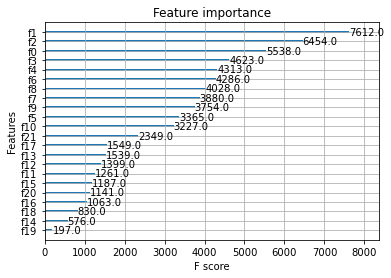

In [56]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Graficar la importancia de las características
plot_importance(model_optimized)
plt.show()


In [57]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Install necessary libraries
!pip install xgboost lime

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Load the dataset
df = pd.read_csv("Master_2022.csv")  

# Clean the data
df = df.dropna()  # Eliminate rows with NaN values
# Alternatively, you could fill NaN values with the mean (if preferred):
# df = df.fillna(df.mean())

# Define features (X) and target variables (y)
X = df.drop(columns=["PFA","PLN", "PLP", "PNR", "PPSD", "PUSC"])
y = df[["PFA","PLN", "PLP", "PNR", "PPSD", "PUSC"]]

# Standardize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the model with optimized hyperparameters
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 300,
    'subsample': 0.8
}

model_optimized = XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse')

# Train the model
model_optimized.fit(X_train, y_train)

# Predictions
y_pred_optimized = model_optimized.predict(X_test)

# Evaluate the model
rmse_optimized = mean_squared_error(y_test, y_pred_optimized, squared=False)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"RMSE Optimizado: {rmse_optimized}")
print(f"R² Optimizado: {r2_optimized}")

# ---- LIME Explanation ----

# Initialize the LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train,  # Use the training data
    mode='regression',      # Since we're doing regression
    training_labels=y_train.values,  # The actual target values
    feature_names=X.columns,  # Feature names
    class_names=y.columns,   # Target variable names
    discretize_continuous=True  # Discretize continuous variables if necessary
)

# Choose a sample to explain (e.g., the first test sample)
sample_idx = 0
explanation = explainer.explain_instance(X_test[sample_idx], model_optimized.predict, num_features=10)

# Show the explanation (showing 10 most important features)
explanation.show_in_notebook()


RMSE Optimizado: 575.7105528755824
R² Optimizado: 0.5548999689394889


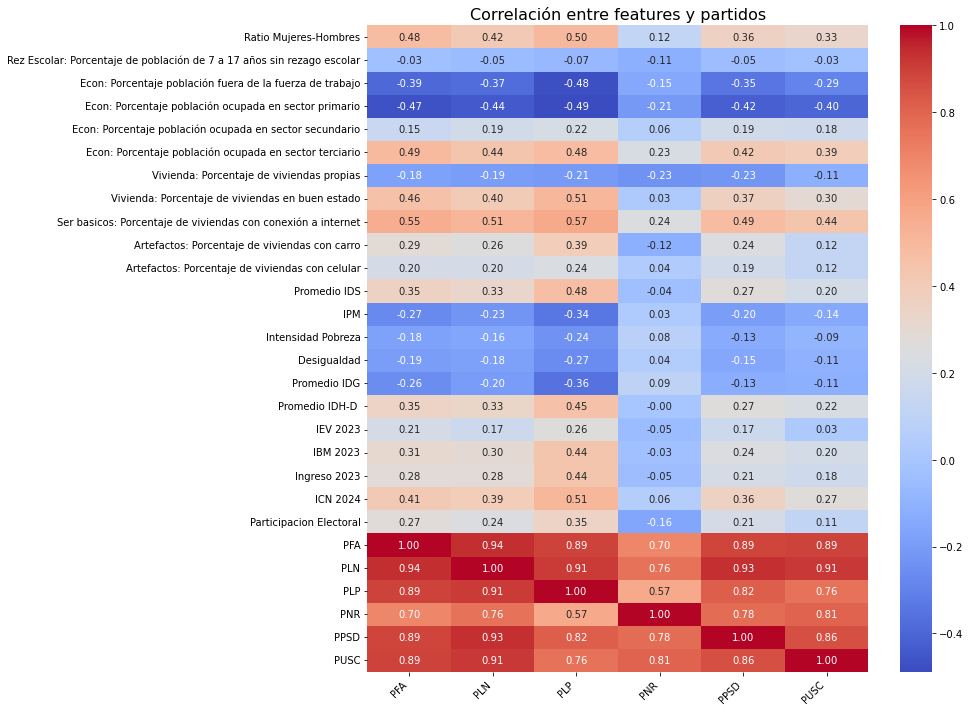

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Definir tamaño de la figura (ajusta según tu pantalla)
plt.figure(figsize=(14, 10))

# Crear el heatmap con anotaciones más legibles
sns.heatmap(
    corr_matrix[y.columns],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    annot_kws={"size": 10}
)

# Títulos y ajustes
plt.title("Correlación entre features y partidos", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Leer y preparar los datos
df = pd.read_csv("Master_2022.csv")
df = df.dropna()

parties = ["PFA", "PLN", "PLP", "PNR", "PPSD", "PUSC"]
y = df[parties].div(df[parties].sum(axis=1), axis=0)  # Normalizar a proporciones
X = df.drop(columns=parties)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelo
base_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Dimensiones para Adjusted R²
n = X_test.shape[0]
p = X_test.shape[1]

# Evaluación
for i, party in enumerate(parties):
    rmse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i], squared=False)
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"Partido {party} - RMSE: {rmse:.4f}, R²: {r2:.4f}, Adjusted R²: {r2_adj:.4f}")



Partido PFA - RMSE: 0.0218, R²: 0.6043, Adjusted R²: 0.4867
Partido PLN - RMSE: 0.0624, R²: 0.2514, Adjusted R²: 0.0288
Partido PLP - RMSE: 0.0214, R²: 0.9016, Adjusted R²: 0.8723
Partido PNR - RMSE: 0.0563, R²: 0.7024, Adjusted R²: 0.6140
Partido PPSD - RMSE: 0.0584, R²: 0.1164, Adjusted R²: -0.1463
Partido PUSC - RMSE: 0.0443, R²: 0.5340, Adjusted R²: 0.3954


In [10]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')
print(f"Cross-validated R²: {scores.mean():.4f}")


Cross-validated R²: 0.5197


In [2]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Usar una sola columna objetivo (por ejemplo, PLN)
y_pln = y["PLN"]

# Definir parámetros a buscar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Inicializar el modelo base
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

# Buscar los mejores parámetros usando solo la predicción para PLN
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train["PLN"])

print("Mejores parámetros para PLN:", grid_search.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mejores parámetros para PLN: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Leer y preparar los datos
df = pd.read_csv("Master_2022.csv")
df = df.dropna()

parties = ["PFA", "PLN", "PLP", "PNR", "PPSD", "PUSC"]
y = df[parties].div(df[parties].sum(axis=1), axis=0)  # Normalizar a proporciones
X = df.drop(columns=parties)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelos base
models = {
    "XGBoost": XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "LightGBM": LGBMRegressor(random_state=42)
}

# Entrenamiento y evaluación
n = X_test.shape[0]
p = X_test.shape[1]

for model_name, base_model in models.items():
    print(f"\n🔍 Evaluando modelo: {model_name}")
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    for i, party in enumerate(parties):
        rmse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i], squared=False)
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print(f"  Partido {party} - RMSE: {rmse:.4f}, R²: {r2:.4f}, Adjusted R²: {r2_adj:.4f}")



🔍 Evaluando modelo: XGBoost
  Partido PFA - RMSE: 0.0218, R²: 0.6043, Adjusted R²: 0.4867
  Partido PLN - RMSE: 0.0624, R²: 0.2514, Adjusted R²: 0.0288
  Partido PLP - RMSE: 0.0214, R²: 0.9016, Adjusted R²: 0.8723
  Partido PNR - RMSE: 0.0563, R²: 0.7024, Adjusted R²: 0.6140
  Partido PPSD - RMSE: 0.0584, R²: 0.1164, Adjusted R²: -0.1463
  Partido PUSC - RMSE: 0.0443, R²: 0.5340, Adjusted R²: 0.3954

🔍 Evaluando modelo: CatBoost
  Partido PFA - RMSE: 0.0209, R²: 0.6385, Adjusted R²: 0.5311
  Partido PLN - RMSE: 0.0562, R²: 0.3929, Adjusted R²: 0.2124
  Partido PLP - RMSE: 0.0179, R²: 0.9313, Adjusted R²: 0.9109
  Partido PNR - RMSE: 0.0491, R²: 0.7736, Adjusted R²: 0.7062
  Partido PPSD - RMSE: 0.0513, R²: 0.3176, Adjusted R²: 0.1148
  Partido PUSC - RMSE: 0.0429, R²: 0.5633, Adjusted R²: 0.4334

🔍 Evaluando modelo: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.


In [16]:
plp_index = parties.index("PLP")



 Importancia de variables para PFA con CatBoost
Ser basicos: Porcentaje de viviendas con conexión a internet: 13.7687
Vivienda: Porcentaje de viviendas en buen estado: 9.6056
Vivienda: Porcentaje de viviendas propias: 6.6427
Econ: Porcentaje población ocupada en sector secundario: 6.4217
Econ: Porcentaje población ocupada en sector terciario: 6.3652
Participacion Electoral: 5.6526
IPM: 4.6555
Artefactos: Porcentaje de viviendas con carro: 4.1331
Econ: Porcentaje población ocupada en sector primario: 4.1144
IEV 2023: 3.7050


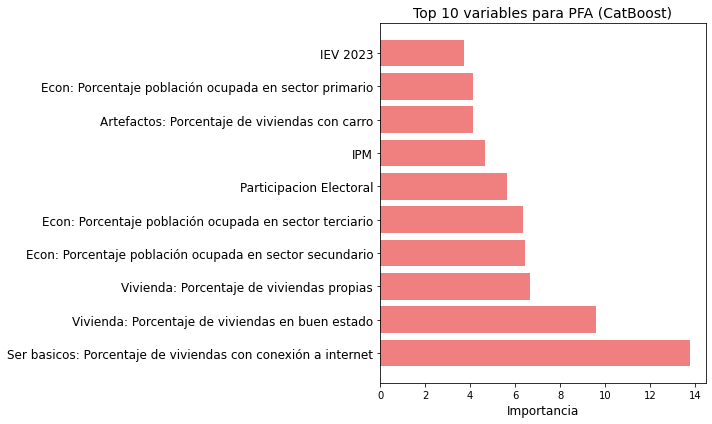


 Importancia de variables para PLN con CatBoost
Econ: Porcentaje población ocupada en sector primario: 12.3062
Participacion Electoral: 11.1930
Vivienda: Porcentaje de viviendas propias: 9.2426
Econ: Porcentaje población ocupada en sector terciario: 7.8934
Promedio IDG: 5.8733
Artefactos: Porcentaje de viviendas con carro: 5.1942
Econ: Porcentaje población fuera de la fuerza de trabajo: 4.5971
IPM: 4.4196
Rez Escolar: Porcentaje de población de 7 a 17 años sin rezago escolar: 4.3484
Ser basicos: Porcentaje de viviendas con conexión a internet: 3.8376


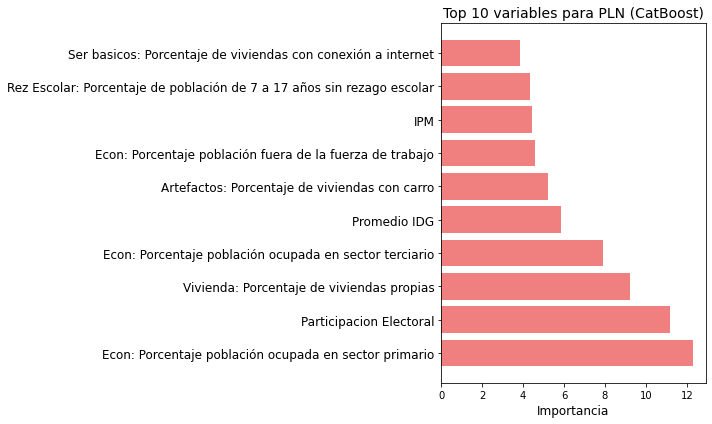


 Importancia de variables para PLP con CatBoost
Ser basicos: Porcentaje de viviendas con conexión a internet: 21.4520
Econ: Porcentaje población ocupada en sector primario: 13.3711
Artefactos: Porcentaje de viviendas con carro: 6.3271
Promedio IDS: 5.4864
Vivienda: Porcentaje de viviendas en buen estado: 5.3174
Participacion Electoral: 5.1111
Econ: Porcentaje población fuera de la fuerza de trabajo: 4.5592
ICN 2024: 3.6181
Promedio IDH-D : 3.4418
IBM 2023: 3.3609


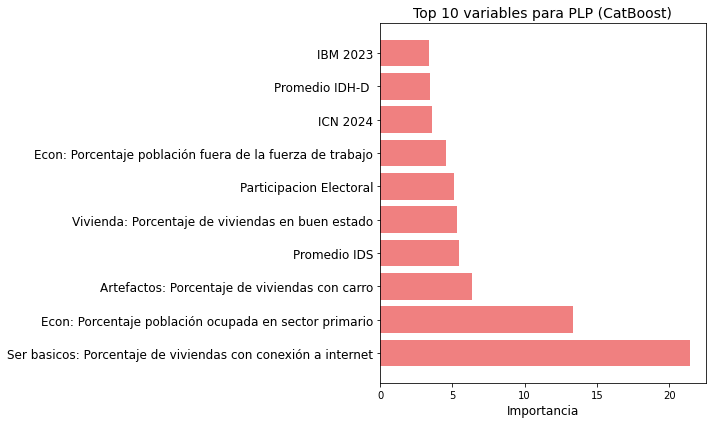


 Importancia de variables para PNR con CatBoost
Participacion Electoral: 22.6673
Artefactos: Porcentaje de viviendas con carro: 11.1432
Vivienda: Porcentaje de viviendas propias: 9.6881
Vivienda: Porcentaje de viviendas en buen estado: 7.5285
IPM: 4.7982
Rez Escolar: Porcentaje de población de 7 a 17 años sin rezago escolar: 4.3443
Econ: Porcentaje población ocupada en sector primario: 3.3188
Econ: Porcentaje población ocupada en sector secundario: 3.2665
Promedio IDG: 3.1520
Artefactos: Porcentaje de viviendas con celular: 3.1182


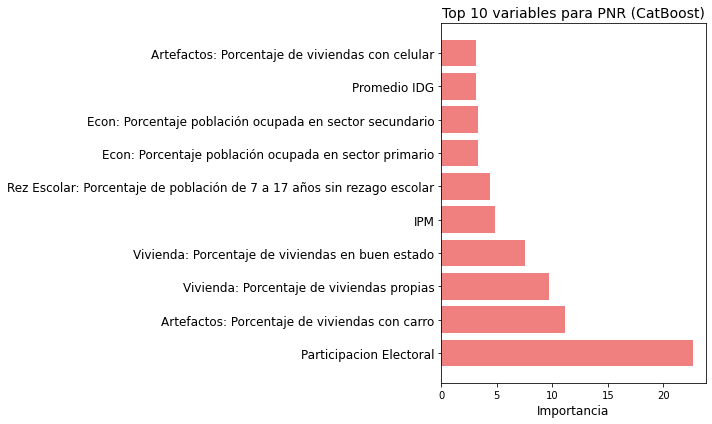


 Importancia de variables para PPSD con CatBoost
Artefactos: Porcentaje de viviendas con carro: 11.0007
IEV 2023: 8.1104
Promedio IDG: 7.7341
Promedio IDH-D : 7.0709
ICN 2024: 6.0720
Desigualdad: 5.9159
Vivienda: Porcentaje de viviendas propias: 5.0906
Econ: Porcentaje población ocupada en sector primario: 4.9340
Artefactos: Porcentaje de viviendas con celular: 4.6951
Intensidad Pobreza: 4.2831


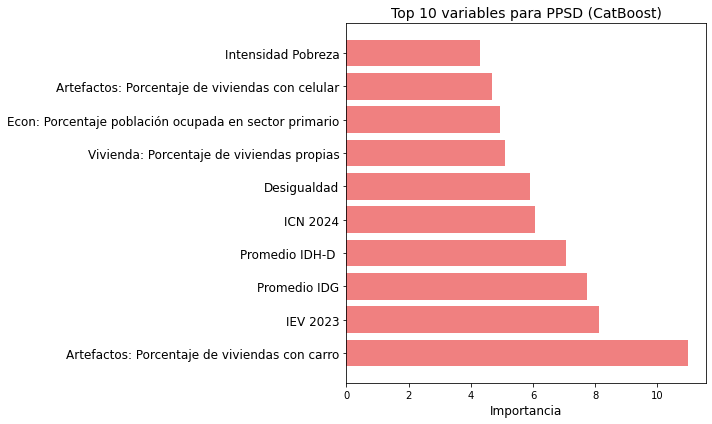


 Importancia de variables para PUSC con CatBoost
Vivienda: Porcentaje de viviendas propias: 12.1923
IEV 2023: 10.2413
Ser basicos: Porcentaje de viviendas con conexión a internet: 7.7890
Artefactos: Porcentaje de viviendas con carro: 5.7176
Vivienda: Porcentaje de viviendas en buen estado: 5.2911
Rez Escolar: Porcentaje de población de 7 a 17 años sin rezago escolar: 5.2866
ICN 2024: 4.9529
Econ: Porcentaje población ocupada en sector primario: 4.9420
Artefactos: Porcentaje de viviendas con celular: 4.4599
Intensidad Pobreza: 4.3921


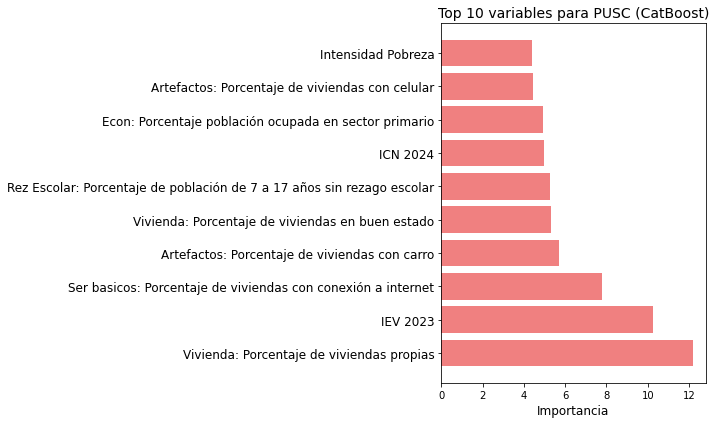

In [21]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import numpy as np

# Reentrenar el modelo CatBoost
catboost_base = CatBoostRegressor(verbose=0, random_state=42)
catboost_model = MultiOutputRegressor(catboost_base)
catboost_model.fit(X_train, y_train)

# Mostrar variables importantes por partido
for party_index, party_name in enumerate(parties):
    print(f"\n Importancia de variables para {party_name} con CatBoost")

    estimator = catboost_model.estimators_[party_index]
    
    # Obtener importancias
    importances = estimator.get_feature_importance()
    feature_names = X.columns
    indices = np.argsort(importances)[::-1]
    top_n = 10

    # Imprimir en consola
    for i in range(top_n):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    # Gráfico horizontal mejorado
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices[:top_n]][::-1], color='lightcoral')
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1], fontsize=12)
    plt.xlabel("Importancia", fontsize=12)
    plt.title(f"Top {top_n} variables para {party_name} (CatBoost)", fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
